## Lectura de datos

In [ ]:
# Leer el archivo CSV
DB_rad <- "~/GitHub/SOLAR_LCOE_UY/data/raw/RadiationSim2024_2044.csv"
data <- read.csv(DB_rad)
options(warn=-1)  # Desactiva advertencias


## Instalación y carga de librerías

In [ ]:
install.packages("triangle")

library(tidyverse)
library(triangle)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching core tidyverse packages ────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ──────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


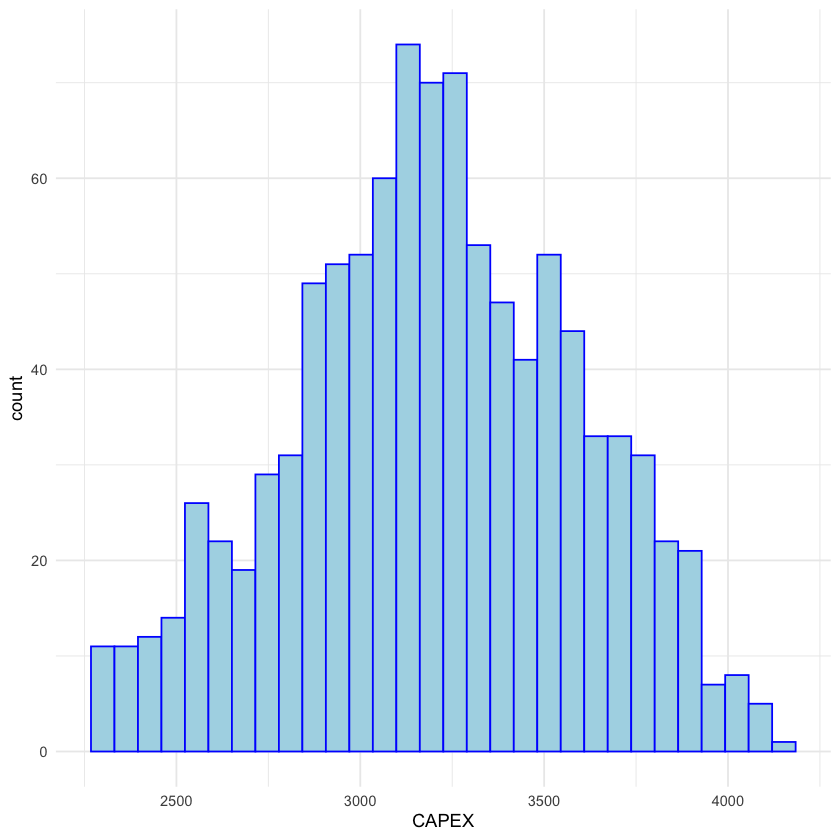

Rows: 7671000 Columns: 3
── Column specification ──────────────────────────────────────────────────────────
Delimiter: ","
dbl  (2): value, id
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'id'. You can override using the `.groups`
argument.
Joining with `by = join_by(id)`


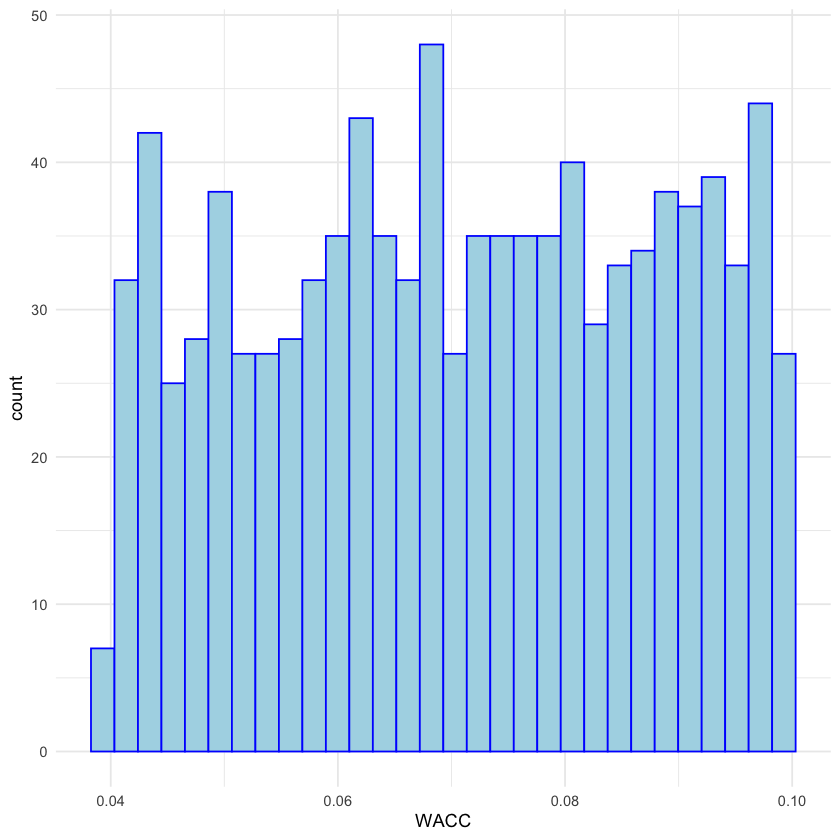

In [ ]:
# average 5.44 paper

set.seed(1995)

Par_MonteCarlo <- tibble(id = seq(1,1000),
                         CAPEX = rtriangle(1000, 2230, 4150, 3190),#capex
                         WACC = runif(1000, 0.04,0.1 ) )# wacc

Par_MonteCarlo |>
  ggplot(aes(CAPEX))+
  geom_histogram(bins = 30, color = "blue", fill = "lightblue" )+
  theme_minimal()

Par_MonteCarlo |>
  ggplot(aes(WACC))+
  geom_histogram(bins = 30, color = "blue", fill = "lightblue" )+
  theme_minimal()


DB_rad <- read_csv("~/GitHub/SOLAR_LCOE_UY/data/raw/RadiationSim2024_2044.csv")


Scenarios <- DB_rad |> group_by(id) |>
  mutate( year = year(date), Output = (value/1000)*0.153*6.455*1)|>
  group_by(id,year) |>
  summarise(yearlyoutput = sum(Output))|>
  group_by(id) |>
  left_join(  Par_MonteCarlo  ) |>
  mutate(t = year-2020,
         FDf =  yearlyoutput*(1/(1 + WACC )^t)) |>
  summarise(CAPEX_MEAN = mean(CAPEX),
            VPf = sum(FDf))|>
  mutate(LCOE = (CAPEX_MEAN/VPf)*1000 )

# VER ESTE CODIGO GRAFICO 1.

Rows: 7671000 Columns: 3
── Column specification ──────────────────────────────────────────────────────────
Delimiter: ","
dbl  (2): value, id
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`geom_smooth()` using formula = 'y ~ x'


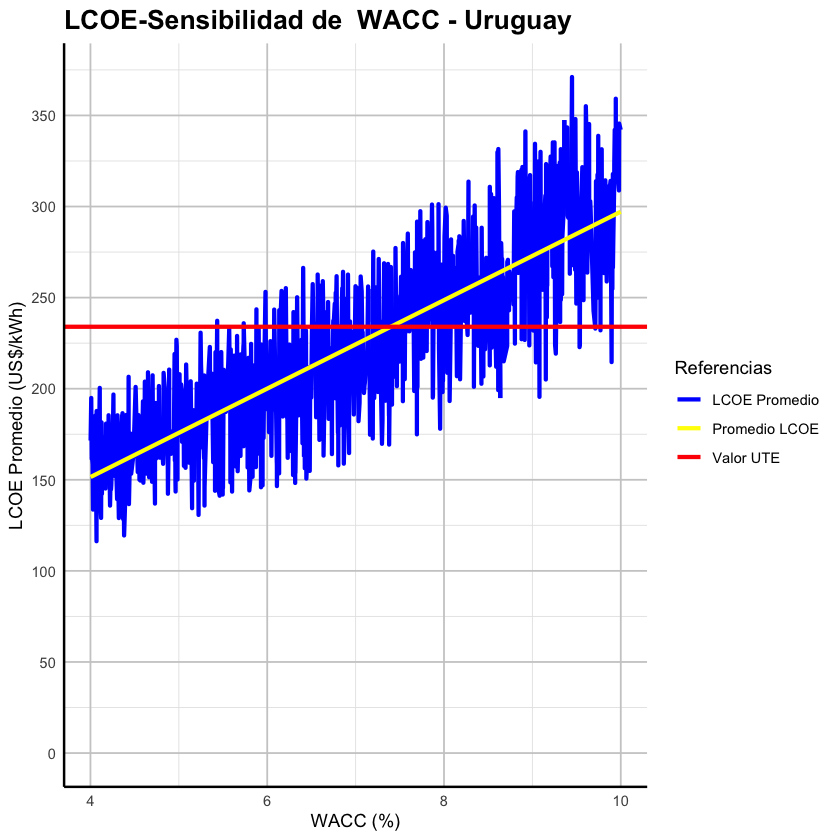

In [ ]:
library(tidyverse)
library(triangle)

# Set seed for reproducibility
set.seed(1995)

# Monte Carlo Simulation Parameters
Par_MonteCarlo <- tibble(
  id = seq(1, 1000),
  inv = rtriangle(1000, 2230, 4150, 3190),  # CAPEX
  rate = runif(1000, 0.04, 0.1)  # WACC
)

# Load Radiation Data
DB_rad <- read_csv("~/GitHub/SOLAR_LCOE_UY/data/raw/RadiationSim2024_2044.csv")

# Compute Scenarios
Scenarios <- DB_rad |>
  group_by(id) |>
  mutate(
    year = year(date),
    Output = (value / 1000) * 0.153 * 6.455 * 1
  ) |>
  group_by(id, year) |>
  summarise(yearlyoutput = sum(Output), .groups = "drop") |>
  left_join(Par_MonteCarlo, by = "id") |>
  mutate(
    t = year - 2020,
    FDf = yearlyoutput * (1 / (1 + rate) ^ t)
  ) |>
  group_by(id, rate) |>
  summarise(
    Inv = mean(inv),
    VPf = sum(FDf),
    .groups = "drop"
  ) |>
  mutate(LCOE = (Inv / VPf) * 1000)

# Agrupar por WACC y calcular el promedio del LCOE
LCOE_avg <- Scenarios |>
  group_by(rate) |>
  summarise(LCOE_mean = mean(LCOE), .groups = "drop") |>
  arrange(rate)

# Valor referencia UTE
valor_UTE <- 0.234 * 1000

ggplot(LCOE_avg, aes(x = rate * 100, y = LCOE_mean)) +
  geom_line(aes(color = "LCOE Promedio"), size = 1.2) +
  geom_smooth(aes(color = "Promedio LCOE"), method = "lm", se = FALSE, size = 1.2) +
  geom_hline(aes(color = "Valor UTE", yintercept = 234), size = 1.2) +
  scale_color_manual(
    name = "Referencias",
    values = c("LCOE Promedio" = "blue",
               "Promedio LCOE" = "yellow",
               "Valor UTE" = "red")
  ) +
  scale_y_continuous(
    breaks = seq(0, max(LCOE_avg$LCOE_mean, 300), 50),
    limits = c(0, NA)
  ) +
  labs(
    x = "WACC (%)",
    y = "LCOE Promedio (US$/kWh)",
    title = "LCOE-Sensibilidad de  WACC - Uruguay"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 16, face = "bold", color = "black"),
    axis.line = element_line(color = "black", linewidth = 0.7),
    panel.grid.major = element_line(color = "grey80"),
    panel.grid.minor = element_line(color = "grey90"),
    legend.position = "right",
    legend.justification = "center",
    legend.box.just = "center"
  )


In [ ]:
# Calcular la probabilidad de que LCOE_mean sea menor que 271 US$/MWh
probabilidad_menor_residencial <- mean(LCOE_avg$LCOE_mean < 271)

# Mostrar el resultado
print(paste("La probabilidad de que el LCOE sea menor que 271 US$/MWh es:", round(probabilidad_menor_residencial * 100, 2), "%"))


[1] "La probabilidad de que el LCOE sea menor que 271 US$/MWh es: 79.9 %"


In [ ]:
library(tidyverse)
library(lubridate)

# Definir valores de referencia
residencial_ref <- 0.234 * 1000  # USD/MWh
negocio_ref <- 0.115 * 1000

# Calcular LCOE por escenario
Scenarios_LCOE <- read_csv("~/GitHub/SOLAR_LCOE_UY/data/raw/RadiationSim2024_2044.csv", show_col_types = FALSE) |>
  group_by(id) |>
  mutate(
    year = year(date),
    Output = (value / 1000) * 0.153 * 6.455   # kWh convertidos a MWh anuales
  ) |>
  group_by(id, year) |>
  summarise(yearly_output = sum(Output), .groups = 'drop') |>
  left_join(Par_MonteCarlo, by = "id") |>
  mutate(
    t = year - 2020,
    FDf = yearly_output / (1 + WACC)^t
  ) |>
  group_by(id, CAPEX, WACC) |>
  summarise(
    VPf = sum(FDf),  # Valor presente de la energía generada
    .groups = 'drop'
  ) |>
  mutate(
    LCOE = (CAPEX / VPf) * 1000  # LCOE en USD/MWh
  )

ERROR: [1m[33mError[39m in `mutate()`:[22m
[1m[22m[36mℹ[39m In argument: `FDf = yearly_output/(1 + WACC)^t`.
[1mCaused by error:[22m
[33m![39m objeto 'WACC' no encontrado


In [ ]:
ggplot(Scenarios_LCOE, aes(x = id, y = LCOE)) +
  geom_point() +
  geom_hline(yintercept = residencial_ref, color = "red", linetype = "dashed", size = 1) +
  annotate("text", x = 1, y = residencial_ref + 10, label = "Residencial (0.234 USD/kWh)", color = "red", hjust = 0) +
  labs(title = "Relación entre ID y LCOE", x = "ID del escenario", y = "LCOE (USD/MWh)") +
  theme_minimal()

In [ ]:
# Ajustar un modelo de regresión lineal a los datos
modelo_LCOE <- lm(LCOE ~ CAPEX, data = Scenarios)

# Crear datos para la línea de tendencia basada en la pendiente promedio
Scenarios <- Scenarios |>
  mutate(LCOE_trend = predict(modelo_LCOE, newdata = Scenarios))

# Graficar LCOE en función del CAPEX con ejes resaltados y título en negrita
ggplot(Scenarios, aes(x = CAPEX, y = LCOE)) +
  geom_point(color = "blue", alpha = 0.5) +
  geom_line(aes(y = LCOE_trend, color = "Promedio LCOE"), size = 1.2) +
  geom_hline(aes(yintercept = 271, color = "Valor UTE"), size = 1) +
  scale_color_manual(
    name = "Referencias",
    values = c("Valor UTE" = "red", "Industrial" = "green", "Promedio LCOE" = "yellow")
  ) +
  scale_y_continuous(
    breaks = seq(0, max(Scenarios$LCOE, 300), 50),
    limits = c(0, NA)
  ) +
  labs(
    x = "CAPEX (US$)",
    y = "LCOE (US$/MWh)",
    title = "LCOE - Sensibilidad de CAPEX - Uruguay"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 16, face = "bold", color = "black"),  # Título en negrita
    axis.line = element_line(color = "black", linewidth = 1.2),
    axis.text = element_text(size = 12, color = "black"),
    axis.title = element_text(size = 14, face = "bold", color = "black"),
    panel.grid.major = element_line(color = "grey80"),
    panel.grid.minor = element_line(color = "grey90")
  )


In [ ]:
# Calcular la probabilidad de que LCOE_mean sea menor que 271 US$/MWh
probabilidad_menor_residencial <- mean(LCOE_avg$LCOE_mean < 271)

# Mostrar el resultado
print(paste("La probabilidad de que el LCOE sea menor que 271 US$/MWh es:", round(probabilidad_menor_residencial * 100, 2), "%"))

In [ ]:

# Probabilidad de que WACC sea menor a 8%
prob_wacc_1 <- mean(Par_MonteCarlo$rate < 0.05) * 100
prob_wacc_2 <- mean(Par_MonteCarlo$rate < 0.08) * 100
prob_wacc_3 <- mean(Par_MonteCarlo$rate < 0.095) * 100
prob_wacc_4 <- mean(Par_MonteCarlo$rate < 0.097) * 100

# Probabilidad de que CAPEX sea menor a 3190
prob_capex_1 <- mean(Par_MonteCarlo$inv < 2500) * 100
prob_capex_2 <- mean(Par_MonteCarlo$inv < 3190) * 100
prob_capex_3 <- mean(Par_MonteCarlo$inv < 3800) * 100
prob_capex_4 <- mean(Par_MonteCarlo$inv < 4000) * 100

# Mostrar resultados
cat(sprintf("Probabilidad de que WACC sea menor a 6.0%%: %.2f%%\n", prob_wacc_1))
cat(sprintf("Probabilidad de que WACC sea menor a 8.0%%: %.2f%%\n", prob_wacc_2))
cat(sprintf("Probabilidad de que WACC sea menor a 9.5%%: %.2f%%\n", prob_wacc_3))
cat(sprintf("Probabilidad de que WACC sea menor a 9.7%%: %.2f%%\n", prob_wacc_4))
cat(sprintf("Probabilidad de que CAPEX sea menor a USD 2500: %.2f%%\n", prob_capex_1))
cat(sprintf("Probabilidad de que CAPEX sea menor a USD 3190: %.2f%%\n", prob_capex_2))
cat(sprintf("Probabilidad de que CAPEX sea menor a USD 3800: %.2f%%\n", prob_capex_3))
cat(sprintf("Probabilidad de que CAPEX sea menor a USD 4000: %.2f%%\n", prob_capex_4))

In [ ]:
# Cargar librerías necesarias
library(tidyverse)
library(lubridate)

# Cargar los datos de radiación
DB_rad <- read_csv("~/GitHub/SOLAR_LCOE_UY/data/raw/RadiationSim2024_2044.csv")

# Convertir la columna 'date' a formato de fecha
DB_rad <- DB_rad %>%
  mutate(date = as.Date(date, format="%Y-%m-%d"))

# Filtrar datos del año 2025
df_2025 <- DB_rad %>%
  filter(year(date) == 2025) %>%
  mutate(month = month(date, label = TRUE))

# Calcular el promedio mensual de radiación en kW/m²
monthly_radiation <- df_2025 %>%
  group_by(month) %>%
  summarise(avg_radiation = mean(value, na.rm = TRUE) / 1000)

# Reemplazar nombres de meses por versiones en español
meses_es <- c("ene", "feb", "mar", "abr", "may", "jun",
              "jul", "ago", "set", "oct", "nov", "dic")

monthly_radiation <- monthly_radiation %>%
  mutate(month = factor(meses_es[as.numeric(month)], levels = meses_es))

# Mostrar los resultados
print(monthly_radiation)

# Graficar la radiación mensual en 2025 con eje Y comenzando en 0
ggplot(monthly_radiation, aes(x = month, y = avg_radiation, group = 1)) +
  geom_line(color = "blue", size = 1) +
  geom_point(color = "red", size = 2) +
  labs(title = "Promedio Mensual de Radiación en 2025 - Uruguay",
       x = "Mes", y = "Radiación Promedio (kW/h/m²)") +
  ylim(0, NA) +  # <-- Asegura que el eje Y comience en 0
  theme_minimal() +
  theme(
    axis.line = element_line(color = "black", linewidth = 1.2),
    axis.text = element_text(size = 12, color = "black"),
    axis.title = element_text(size = 14, face = "bold", color = "black"),
    panel.grid.major = element_line(color = "grey80"),
    panel.grid.minor = element_line(color = "grey90")
  )


In [ ]:
library(tidyverse)
library(lubridate)
library(triangle)

# Fija la semilla para reproducibilidad
set.seed(1995)

# Parámetros del Monte Carlo (Inversión y tasa de descuento)
Par_MonteCarlo <- tibble(
  id = seq(1, 1000),
  inv = rtriangle(1000, 2230, 4150, 3190),  # CAPEX
  rate = runif(1000, 0.04, 0.1)             # WACC
)

# Carga y preparación de datos
datos <- read.csv("~/GitHub/SOLAR_LCOE_UY/data/raw/RadiationSim2024_2044.csv") %>%
  mutate(date = as.Date(date))

# Extraer los años únicos
anios <- unique(year(datos$date))

# Lista para almacenar los resultados
resultados <- list()

# Loop para calcular el LCOE en cada año
for (anio in anios) {
  Simulacion <- datos %>%
    mutate(year = year(date),
           Output = (value / 1000) * 0.153 * 6.455 * 1) %>%
    filter(year == anio) %>%
    group_by(id) %>%
    summarise(yearlyoutput = sum(Output), .groups = 'drop') %>%
    left_join(Par_MonteCarlo, by = "id") %>%
    mutate(
      lifetime = 1,
      LCOE = (inv + (0 / (1 + rate))) / yearlyoutput * 100
    )

  resultados[[as.character(anio)]] <- Simulacion
}

# Graficar histogramas con líneas de densidad y ejes resaltados por año
for (anio in anios) {
  plot <- ggplot(resultados[[as.character(anio)]], aes(LCOE)) +
    geom_histogram(aes(y = ..density..),
                   color = "blue", fill = "lightblue", bins = 30, alpha = 0.6) +
    geom_density(color = "red", linewidth = 1.2) +
    theme_minimal() +
    labs(title = paste("Distribución del LCOE para", anio),
         x = "LCOE (USD/MWh)",
         y = "Densidad") +
    theme(
      axis.line = element_line(color = "black", linewidth = 1.2),             # Ejes resaltados
      axis.text = element_text(size = 12, color = "black"),                   # Texto de ejes más grande y visible
      axis.title = element_text(size = 14, face = "bold", color = "black"),   # Títulos resaltados en negrita
      panel.grid.major = element_line(color = "grey80"),
      panel.grid.minor = element_line(color = "grey90")
    )

  print(plot)
}



In [ ]:
install.packages("gridExtra")


In [ ]:
install.packages("patchwork")

In [ ]:
library(tidyverse)
library(lubridate)
library(triangle)
library(patchwork)

# Fija la semilla para reproducibilidad
set.seed(1995)

# Parámetros del Monte Carlo
Par_MonteCarlo <- tibble(
  id = seq(1, 1000),
  CAPEX = rtriangle(1000, 2230, 4150, 3190),
  WACC = runif(1000, 0.04, 0.1)
)

# Carga y preparación de datos
datos <- read.csv("~/GitHub/SOLAR_LCOE_UY/data/raw/RadiationSim2024_2044.csv") %>%
  mutate(date = as.Date(date))

# Extraer los años únicos
anios <- unique(year(datos$date))

# Generar gráficos usando ggplot y guardarlos en una lista
graficos <- map(anios, function(anio) {
  Simulacion <- datos %>%
    mutate(year = year(date),
           Output = (value / 1000) * 0.153 * 6.455) %>%
    filter(year == anio) %>%
    group_by(id) %>%
    summarise(yearlyoutput = sum(Output), .groups = 'drop') %>%
    left_join(Par_MonteCarlo, by = "id") %>%
    mutate(
      lifetime = 1,
      LCOE = (CAPEX + (0 / (1 + WACC))) / yearlyoutput * 100
    )

  ggplot(Simulacion, aes(LCOE)) +
    geom_histogram(aes(y = ..density..), bins = 30, fill = "#69b3a2", color = "#1f7a70", alpha = 0.8) +
    geom_density(color = "#FF5733", linewidth = 1) +
    theme_light() +
    labs(
      title = paste("Distribución del LCOE - Año", anio),
      x = "LCOE (USD/MWh)",
      y = "Frecuencia"
    ) +
    theme(
      plot.title = element_text(size = 8, face = "bold"),
      axis.title = element_text(size = 6),
      axis.text = element_text(size = 6)
    )
})

# Combina todos los gráficos usando patchwork
wrap_plots(graficos, ncol = 3) +
  plot_annotation(
    title = 'Simulación Monte Carlo del LCOE-Uruguay (2024-2044)',
    theme = theme(
      plot.title = element_text(size = 16, face = "bold", hjust = 0.5)
    )
  )


# Ver celda que da error con datos_resumen que no existe

In [ ]:
# Tabla de variación promedio mensual del LCOE (2025)
# tabla_variacion_LCOE <- datos_resumen %>%
#   select(month, Avg_LCOE, LCOE_pct) %>%
#   rename(
#     Mes = month,
#     LCOE_Promedio = Avg_LCOE,
#     Variacion_LCOE_Pct = LCOE_pct
#   )

# # Mostrar tabla final
# tabla_variacion_LCOE


In [ ]:
# Gráfica con cuadrícula visible y ejes resaltados
Scenarios %>%
  ggplot(aes(VPf / 1000, LCOE)) +
  geom_point(color = "blue") +
  geom_smooth(method = "lm", se = FALSE, color = "yellow") +
  geom_smooth(aes(linetype = "Promedio", color = "Promedio"), method = "lm", se = FALSE) +
  geom_hline(aes(yintercept = 271, linetype = "UTE", color = "UTE"), size = 1.2) +
  scale_linetype_manual(
    name = "Referencias",
    values = c("UTE" = "solid", "Promedio" = "solid")
  ) +
  scale_color_manual(
    name = "Referencias",
    values = c("UTE" = "red", "Promedio" = "yellow")
  ) +
  scale_y_continuous(
    breaks = seq(0, max(Scenarios$LCOE, 400), 50),
    limits = c(0, NA)
  ) +
  labs(
    x = "Generación Solar Agregada (MWh descontado)",
    y = "LCOE (USD/MWh)",
    title = "LCOE - Sensibilidad Generación Solar Agregada - Uruguay (2024-2044)"
  ) +
  theme_bw() +  # Tema con cuadrícula de fondo
  theme(
    panel.grid.major = element_line(color = "grey80", linewidth = 0.7),  # Cuadrícula principal visible
    panel.grid.minor = element_line(color = "grey90", linewidth = 0.5),  # Cuadrícula secundaria visible
    axis.line = element_line(color = "black", linewidth = 1.2),          # Ejes claramente marcados
    axis.title = element_text(size = 12, face = "bold", color = "black"),
    axis.text = element_text(size = 11, color = "black"),
    plot.title = element_text(size = 12, face = "bold", hjust = 0.5)
  )


In [ ]:
library(tidyverse)
library(lubridate)
library(triangle)

# Set seed para reproducibilidad
set.seed(1995)

# Parámetros Monte Carlo (1000 escenarios)
Par_MonteCarlo <- tibble(
  id = seq(1,1000),
  CAPEX = rtriangle(1000, 2230, 4150, 3190),  # CAPEX: costo de inversión inicial
  WACC = runif(1000, 0.04, 0.1)             # WACC: tasa de descuento
)

# Carga de datos de radiación solar
DB_rad <- read_csv("~/GitHub/SOLAR_LCOE_UY/data/raw/RadiationSim2024_2044.csv")

# Procesamiento de datos para el periodo 2024-2044
Scenarios <- DB_rad %>%
  mutate(year = year(date), Output = (value / 1000) * 0.153 * 6.455) %>%  # Cálculo de generación solar
  group_by(id, year) %>%
  summarise(yearlyoutput = sum(Output), .groups = 'drop') %>%
  left_join(Par_MonteCarlo, by = "id") %>%  # Agregar datos de CAPEX y WACC
  mutate(
    t = year - 2020,  # Año relativo para el descuento
    FDf = yearlyoutput * (1 / (1 + WACC)^t)  # Flujo descontado de generación solar
  ) %>%
  group_by(id) %>%
  summarise(
    CAPEX_mean = mean(CAPEX),  # Promedio de inversión inicial
    VPf = sum(FDf),   # Valor presente de la generación solar descontada
    LCOE = (CAPEX_mean / VPf) * 1000  # Cálculo del LCOE en USD/MWh
  )

# Gráfica con cuadrícula visible y ejes claramente marcados
Scenarios %>%
  ggplot(aes(VPf / 1000, LCOE)) +
  geom_point(color = "blue") +
  geom_smooth(aes(linetype = "Promedio", color = "Promedio"), method = "lm", se = FALSE) +
  geom_hline(aes(yintercept = 271, linetype = "UTE", color = "UTE"), size = 1.2) +
  scale_y_continuous(
    breaks = seq(0, max(Scenarios$LCOE, 300), 50),
    limits = c(0, NA)
  ) +
  labs(
    x = "Generación Solar Agregada (MWh descontado)",
    y = "LCOE (USD/MWh)",
    title = "LCOE - Sensibilidad Generación Solar Agregada - Uruguay (2024-2044)"
  ) +
  scale_linetype_manual(
    name = "Referencias",
    values = c("UTE" = "solid", "Promedio" = "solid")
  ) +
  scale_color_manual(
    name = "Referencias",
    values = c("UTE" = "red", "Promedio" = "yellow")
  ) +
  theme_bw() +  # Añade cuadrícula visible
  theme(
    panel.grid.major = element_line(color = "grey80", linewidth = 0.7), # Cuadrícula principal visible
    panel.grid.minor = element_line(color = "grey90", linewidth = 0.5), # Cuadrícula secundaria visible
    axis.line = element_line(color = "black", linewidth = 1.2),         # Ejes resaltados claramente
    axis.title = element_text(size = 13, face = "bold", color = "black"),
    axis.text = element_text(size = 11, color = "black"),
    plot.title = element_text(size = 13, face = "bold", hjust = 0.5),
    legend.position = "right"
  )


In [ ]:
library(tidyverse)
library(lubridate)
library(triangle)

# Set seed para reproducibilidad
set.seed(1995)

# Parámetros Monte Carlo (1000 escenarios)
Par_MonteCarlo <- tibble(
  id = seq(1,1000),
  CAPEX = rtriangle(1000, 2230, 4150, 3190),  # CAPEX
  WACC = runif(1000, 0.04, 0.1)             # WACC
)

# Carga de datos
DB_rad <- read_csv("~/GitHub/SOLAR_LCOE_UY/data/raw/RadiationSim2024_2044.csv")

# Procesamiento para 2024-2044, sin promedios finales para tener múltiples puntos
Scenarios <- DB_rad %>%
  mutate(year = year(date), Output = (value / 1000) * 0.153 * 6.455) %>%
  group_by(id, year) %>%
  summarise(yearlyoutput = sum(Output), .groups = 'drop') %>%
  left_join(Par_MonteCarlo, by = "id") %>%
  mutate(
    t = year - 2020,
    FDf = yearlyoutput * (1 / (1 + WACC)^t)
  ) %>%
  group_by(id) %>%
  summarise(
    CAPEX_mean = mean(CAPEX),
    VPf = sum(FDf),
    LCOE = (CAPEX_mean / VPf) * 1000
  )

# Gráfica con cuadrícula visible y ejes claramente marcados
Scenarios %>%
  ggplot(aes(VPf / 1000, LCOE)) +
  geom_point(color = "blue") +
  geom_smooth(method = "lm", se = FALSE, color = "yellow") +
  geom_hline(yintercept = 271, color = "red", size = 1.2) +
  scale_y_continuous(
    breaks = seq(0, max(Scenarios$LCOE, 300), 50),
    limits = c(0, NA)
  ) +
  labs(
    x = "Generación Solar Agregada (MWh descontado)",
    y = "LCOE (USD/MWh)",
    title = "LCOE - Sensibilidad Generación Solar Agregada - Uruguay (2024-2044)"
  ) +
  theme_bw() +  # Añade cuadrícula visible
  theme(
    panel.grid.major = element_line(color = "grey80", linewidth = 0.7), # Cuadrícula principal resaltada
    panel.grid.minor = element_line(color = "grey90", linewidth = 0.5), # Cuadrícula secundaria visible
    axis.line = element_line(color = "black", linewidth = 1.2),         # Ejes claramente resaltados
    axis.title = element_text(size = 13, face = "bold", color = "black"),
    axis.text = element_text(size = 11, color = "black"),
    plot.title = element_text(size = 12, face = "bold", hjust = 0.5)
  )


In [ ]:
######## 26/05/25

In [ ]:
library(ggplot2)

ggplot(Scenarios, aes(x = LCOE)) +
  geom_histogram(bins = 30, fill = "skyblue", color = "black", alpha = 0.7) +
  geom_density(color = "darkblue", size = 1) +
  labs(title = "Distribución de LCOE", x = "LCOE (US$/MWh)", y = "Frecuencia") +
  theme_minimal()

In [ ]:
colnames(Scenarios)

### Verificar el siguiente código por el tema del WACC

In [ ]:
library(tidyverse)  # Si no lo tienes ya cargado
# Renombrar las variables usando rename() de dplyr
library(dplyr)

ggplot(Scenarios, aes(x = CAPEX_mean, y = LCOE, color = WACC)) +
  geom_point(alpha = 0.7) +
  scale_color_viridis_c() +
  labs(title = "Relación entre CAPEX y LCOE (coloreado por WACC)",
       x = "CAPEX (US$)", y = "LCOE (US$/MWh)") +
  theme_minimal()

In [ ]:
library(plotly)

fig <- plot_ly(Scenarios, x=~CAPEX, y=~LCOE, color=~factor(WACC),
               type='scatter', mode='markers') %>%
  layout(title="CAPEX vs LCOE (Interactivo)",
         xaxis=list(title="CAPEX (USD)"),
         yaxis=list(title="LCOE (USD/MWh)"))

fig

In [ ]:
# Asumiendo que ya tienes el data frame Scenarios generado según tu notebook

# Probabilidad de que WACC sea menor a 8%
prob_wacc <- mean(Par_MonteCarlo$rate < 0.08) * 100

# Probabilidad de que CAPEX sea menor a 3190
prob_capex <- mean(Par_MonteCarlo$inv < 3190) * 100

# Mostrar resultados
cat(sprintf("Probabilidad de que WACC sea menor a 8%%: %.2f%%\n", prob_wacc))
cat(sprintf("Probabilidad de que CAPEX sea menor a USD 3190: %.2f%%\n", prob_capex))